# Import Dependencies

In [1]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from bs4 import BeautifulSoup
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
py.init_notebook_mode(connected = True)

In [3]:
import os 
os.chdir("D:\mbti_ml_project")

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Loading the Datasets

In [5]:
train = pd.read_csv("mbti_1.csv")
us = pd.read_csv("Users.csv")
ps = pd.read_csv("ForumMessages.csv")
mbti = {"I" : "Introversion", "E" : "Extroversion", "N" : "Intutions", "S" : "Sensing", "T" : "Thinking", "F" : "Feeling", "J" : "Judging", "P" : "Perceiving"}

In [6]:
train.shape

(8675, 2)

Ploting the personality types

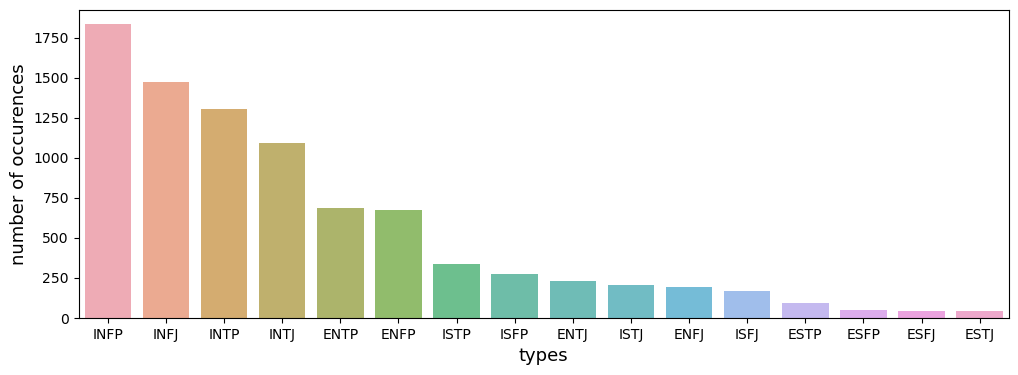

In [7]:
cnt_sns = train['type'].value_counts()
plt.figure(figsize = (12,4))
sns.barplot(cnt_sns.index, cnt_sns.values, alpha=0.8)
plt.ylabel("number of occurences", fontsize = 13)
plt.xlabel("types", fontsize = 13)
plt.show()

In [8]:
ps.head()

,Id,ForumTopicId,PostUserId,PostDate,ReplyToForumMessageId,Message,Medal,MedalAwardDate
0,1,1,478,04/28/2010 23:13:08,NaN,<div>In response to a comment on the No Free H...,NaN,NaN
1,2,2,606,04/29/2010 15:48:46,NaN,"Hi, I'm interested in participating in the con...",NaN,NaN
2,3,2,478,04/29/2010 15:48:46,NaN,"Tanya,<div><br></div><div>Good to hear from yo...",NaN,NaN
3,4,2,368,04/29/2010 15:48:46,NaN,"Hi Tanya, <br><br>Kaggle will maintain a ratin...",NaN,NaN
4,5,3,634,04/30/2010 14:32:29,NaN,"Hi,<br><br>I just read in csv files and I've g...",NaN,NaN


In [9]:
ps["Message"] = ps["Message"].fillna('')

In [10]:
ps_join = ps.groupby('PostUserId')['Message'].agg(lambda col: ' '.join(col)).reset_index()

# Preparing ExtraTreeClassifier model

In [11]:
extra_tree_classifier = ExtraTreesClassifier(n_estimators=20, max_depth=4, n_jobs= -1)
tfidf = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
tsvd = TruncatedSVD(n_components=10)
model = Pipeline([('tfidfi', tfidf), ('tsvdi', tsvd), ('etc', extra_tree_classifier)])

In [12]:
kfolds = StratifiedKFold(n_splits=5, shuffle= True, random_state=1)

In [13]:
np.random.seed(1)

scoring = {'acc' : 'accuracy',
           'neg_log_loss' : 'neg_log_loss',
           'f1_micro' : 'f1_micro'}

results = cross_validate(model, train['posts'], train['type'], cv=kfolds,
                        scoring = scoring, n_jobs=-1)

In [14]:
print("CV Accuracy: {:0.4f}(+/- {:0.4f})".format(np.mean(results['test_acc']),
                                                np.std(results['test_acc'])))
print("CV F1: {:0.4f}(+/- {:0.4f})".format(np.mean(results['test_f1_micro']),
                                                np.std(results['test_f1_micro'])))
print("CV Logloss: {:0.4f}(+/- {:0.4f})".format(np.mean(results['test_neg_log_loss']),
                                                np.std(results['test_neg_log_loss'])))

CV Accuracy: 0.2968(+/- 0.0142)
CV F1: 0.2968(+/- 0.0142)
CV Logloss: -2.1408(+/- 0.0096)


# Extracting the text from the dataset using BeautifulSoup

In [15]:
def cleanText(text):
    text = BeautifulSoup(text, 'lxml').text
    text = re.sub(r'\|\|\|', r'',text)
    text = re.sub(r'http\S+', r'<URL>',text)
    return text

In [16]:
train['clean_posts'] = train['posts'].apply(cleanText)

In [17]:
train.head()

,type,posts,clean_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,'<URL> and intj moments <URL> sportscenter n...
1,ENTP,'I'm finding the lack of me in these posts ver...,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...,"'Good one _____ <URL> course, to which I sa..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...,'You're fired.That's another silly misconcepti...


# Preparing the Naive Bayes model

In [18]:
np.random.seed(1)

tfidf2 = CountVectorizer(ngram_range=(1,1),
                        stop_words='english',
                        lowercase=True,
                        max_features=5000)

model_naive_bayes = Pipeline([('tfidf1', tfidf2), ('nb', MultinomialNB())])

results_nb = cross_validate(model_naive_bayes, train['clean_posts'], train['type'], cv=kfolds,
                           scoring = scoring, n_jobs=-1)

In [19]:
print("CV Accuracy: {:0.4f}(+/- {:0.4f})".format(np.mean(results_nb['test_acc']),
                                                np.std(results_nb['test_acc'])))
print("CV F1: {:0.4f}(+/- {:0.4f})".format(np.mean(results_nb['test_f1_micro']),
                                                np.std(results_nb['test_f1_micro'])))
print("CV Logloss: {:0.4f}(+/- {:0.4f})".format(np.mean(-1*results_nb['test_neg_log_loss']),
                                                np.std(results_nb['test_neg_log_loss'])))

CV Accuracy: 0.5636(+/- 0.0121)
CV F1: 0.5636(+/- 0.0121)
CV Logloss: 6.1370(+/- 0.3659)


# Preparing the LogisticRegression model

In [20]:
np.random.seed(1)

tfidf2 = CountVectorizer(ngram_range=(1,1),
                        stop_words='english',
                        lowercase=True,
                        max_features=5000)

model_logistic_reg = Pipeline([('tfidf1', tfidf2), ('lr', LogisticRegression(class_weight="balanced", C = 0.005))])

results_lr = cross_validate(model_logistic_reg, train['clean_posts'], train['type'], cv=kfolds,
                           scoring = scoring, n_jobs=-1)

In [21]:
print("CV Accuracy: {:0.4f}(+/- {:0.4f})".format(np.mean(results_lr['test_acc']),
                                                np.std(results_lr['test_acc'])))
print("CV F1: {:0.4f}(+/- {:0.4f})".format(np.mean(results_lr['test_f1_micro']),
                                                np.std(results_lr['test_f1_micro'])))
print("CV Logloss: {:0.4f}(+/- {:0.4f})".format(np.mean(-1*results_lr['test_neg_log_loss']),
                                                np.std(results_lr['test_neg_log_loss'])))

CV Accuracy: 0.6578(+/- 0.0135)
CV F1: 0.6578(+/- 0.0135)
CV Logloss: 1.3075(+/- 0.0136)


In [22]:
train_sizes, train_scores, test_scores = \
    learning_curve(model_logistic_reg, train['clean_posts'], train['type'], cv=kfolds,
                           scoring = 'f1_micro', n_jobs=-1, train_sizes = np.linspace(.1, 1.0, 10), random_state=1)

# Learning Graph of Training score and CrossValidation score

In [24]:
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,3)):
    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_score_mean = np.mean(train_scores, axis = 1)
    train_score_std = np.std(train_scores, axis = 1)
    test_score_mean = np.mean(test_scores, axis = 1)
    test_score_std = np.std(test_scores, axis = 1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_score_mean - train_score_std,
                    train_score_mean + train_score_std, alpha=0.1,
                    color = 'r')
    plt.fill_between(train_sizes, test_score_mean - test_score_std,
                    test_score_mean + test_score_std, alpha=0.1,
                    color = 'g')
    plt.plot(train_sizes, test_score_mean, 'o-', color='g',
            label = "Cross-validation score")
    
    plt.legend(loc='best')
    return plt

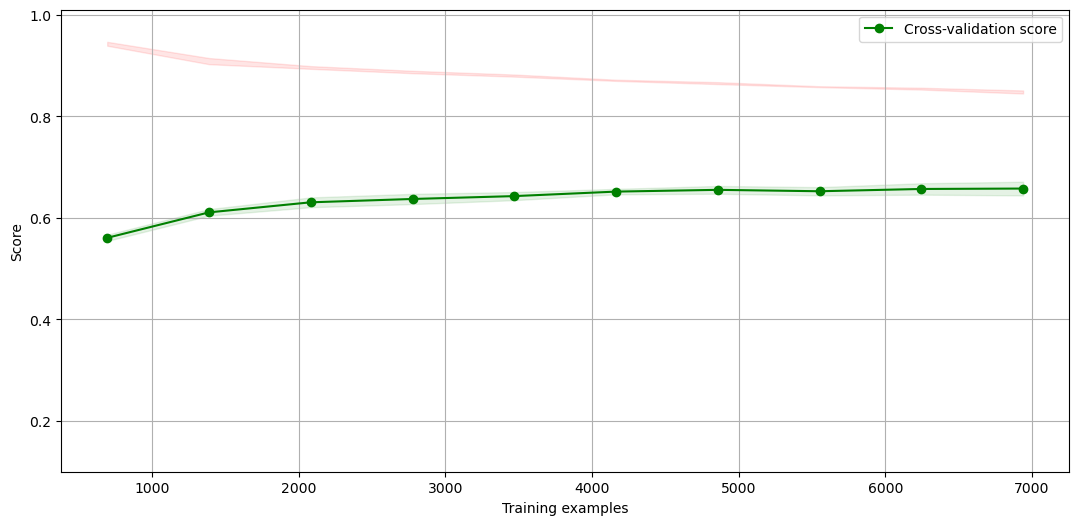

In [25]:
plot_learning_curve(train['posts'], train['type'], train_sizes, train_scores, test_scores, ylim=(0.1, 1.01), figsize=(13,6))
plt.show()

In [27]:
ps_join['clean_comments'] = ps_join['Message'].apply(cleanText)

# Predictive model of LogisticRegression

In [28]:
model_logistic_reg.fit(train['clean_posts'], train['type'])
pred_all = model_logistic_reg.predict(ps_join['clean_comments'])

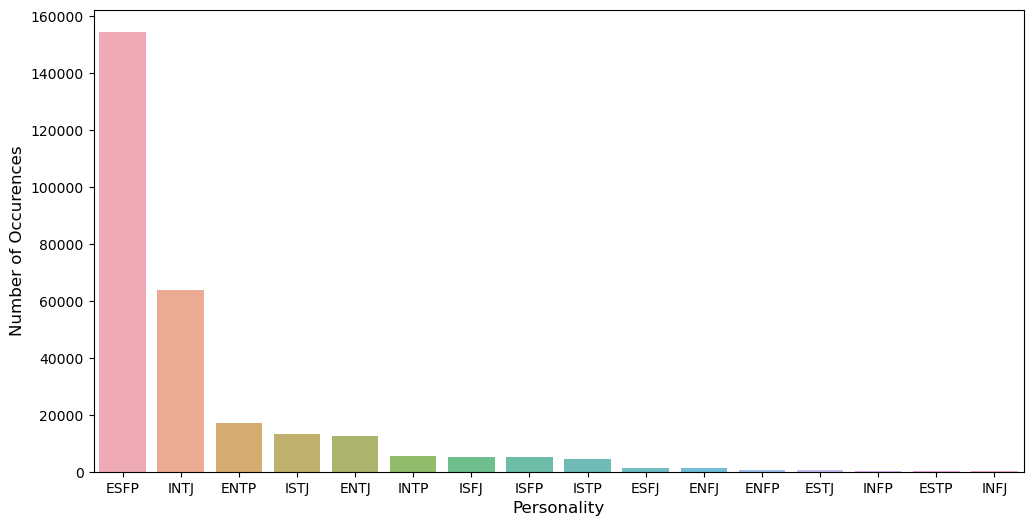

In [32]:
cnt_all = np.unique(pred_all, return_counts=True)

pred_df = pd.DataFrame({'personality' : cnt_all[0], 'count': cnt_all[1]},
                      columns=['personality', 'count'], index = None)

pred_df.sort_values('count', ascending=False, inplace=True)

plt.figure(figsize=(12,6))
sns.barplot(pred_df['personality'], pred_df['count'], alpha=0.8)
plt.ylabel("Number of Occurences", fontsize=12)
plt.xlabel("Personality", fontsize=12)
plt.show()

# Description of each personality

In [33]:
pred_df['percent'] = pred_df['count']/pred_df['count'].sum()
pred_df['description'] = pred_df['personality'].apply(lambda x: " ".join([mbti[l] for l in list(x)]))

In [34]:
pred_df

,personality,count,percent,description
5,ESFP,154413,0.539210,Extroversion Sensing Feeling Perceiving
10,INTJ,63913,0.223184,Introversion Intutions Thinking Judging
3,ENTP,17061,0.059577,Extroversion Intutions Thinking Perceiving
14,ISTJ,13161,0.045958,Introversion Sensing Thinking Judging
2,ENTJ,12524,0.043734,Extroversion Intutions Thinking Judging
11,INTP,5659,0.019761,Introversion Intutions Thinking Perceiving
12,ISFJ,5175,0.018071,Introversion Sensing Feeling Judging
13,ISFP,5121,0.017883,Introversion Sensing Feeling Perceiving
15,ISTP,4349,0.015187,Introversion Sensing Thinking Perceiving
4,ESFJ,1444,0.005042,Extroversion Sensing Feeling Judging


# Graphical representation of personality by percent

In [38]:
labels = pred_df['description']
sizes = pred_df['percent']*100

trace = go.Pie(labels = labels, values = sizes)
layout = go.Layout(title = "Kaggle user personality distribution")

data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)